## 環境設定及整合


### Python 套件導入

In [4]:
import os
import numpy as np
import pandas as pd
import chardet
import datetime
import pandas as pd
import jieba
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, f_regression, chi2
from ckip_transformers.nlp import CkipWordSegmenter, CkipPosTagger, CkipNerChunker
import jieba
from TCSP import read_stopwords_list
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn import metrics
import matplotlib.pyplot as plt

### 資料集下載及讀取

In [5]:
# root = r'C:\Users\tony\Desktop\bda_project\BDA'
root ='../bda2024_mid_dataset'
data = {}
for filename in os.listdir(root):
	if '.ipynb_checkpoints' in filename:
		continue  # 忽略 .ipynb_checkpoints 目录
	words = filename.split('_')
	readable_filename = ''.join(words[-2:])
	filepath = f'{root}/{filename}'
	print(f'正在載入 {readable_filename} ...')
	df = pd.read_csv(filepath, encoding='utf-8')
	print(df)
	data[readable_filename[:-4]] = df
	print(f'成功載入 {readable_filename}。')

正在載入 討論數據dcard.csv ...
                         id  forum      s_name s_area_name  \
0       1646109801927_F0DCU  forum  校園聊天-Dcard          股票   
1       1646109801940_F0DCU  forum  校園聊天-Dcard          股票   
2       1646115341451_F0DCU  forum  校園聊天-Dcard          股票   
3       1646113689192_F0DCU  forum  校園聊天-Dcard          股票   
4       1646068286032_F0DCU  forum  校園聊天-Dcard          股票   
...                     ...    ...         ...         ...   
231315  1709239679954_F0DCU  forum  校園聊天-Dcard          股票   
231316  1709248667603_F0DCU  forum  校園聊天-Dcard          股票   
231317  1709244637745_F0DCU  forum  校園聊天-Dcard          股票   
231318  1709278750256_F0DCU  forum  校園聊天-Dcard          股票   
231319  1709244637803_F0DCU  forum  校園聊天-Dcard          股票   

                      post_time                 title      author  \
0       2022-03-01 00:00:18.000        #分享 投資股票個人經驗分享      靜宜大學/F   
1       2022-03-01 00:00:22.000        #分享 投資股票個人經驗分享      銘傳大學/F   
2       2022-03-01 00:07:

/var/folders/gf/q242kxcx471dfq8lmv99k_y80000gn/T/ipykernel_42737/2246065747.py:11: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath, encoding='utf-8')


         stock_name stock_symbol  foreign_investor_bought  \
0                信大         1109                     2000   
1                信大         1109                        0   
2                信大         1109                    11000   
3                信大         1109                    13000   
4                信大         1109                    68000   
...             ...          ...                      ...   
998026          現觀科         6906                    28000   
998027        金萬林-創         6645                    14000   
998028  群益ESG投等債20+       00937B                  1511400   
998029         玖鼎電力         4588                   389000   
998030      世界健身-KY         2762                    10000   

        foreign_investor_sold  investment_trust_bought  investment_trust_sold  \
0                        3000                        0                      0   
1                       11000                        0                      0   
2                       

/var/folders/gf/q242kxcx471dfq8lmv99k_y80000gn/T/ipykernel_42737/2246065747.py:11: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath, encoding='utf-8')


        stock_name stock_symbol   open   high    low  close  volume  \
0               日馳         1526  47.55  48.45  47.55  48.30     138   
1               日馳         1526  48.30  48.30  47.40  47.95     153   
2               日馳         1526  48.45  48.70  47.80  48.10     120   
3               日馳         1526  47.95  47.95  47.55  47.60     165   
4               日馳         1526  47.65  47.65  45.30  45.65     514   
...            ...          ...    ...    ...    ...    ...     ...   
1154220         統一         1216  76.20  78.60  76.00  77.20   20607   
1154221         統一         1216  76.80  78.80  76.40  78.80   16466   
1154222         統一         1216  78.00  78.70  77.10  78.20   16015   
1154223         統一         1216  78.00  78.00  76.30  77.40    8524   
1154224         統一         1216  76.10  77.20  75.80  76.20    8347   

                        date  
0        2022-03-01 00:00:00  
1        2022-03-02 00:00:00  
2        2022-03-03 00:00:00  
3        2022-03-04 00:

In [6]:
data.keys()

dict_keys(['討論數據dcard', '內容數據新聞3', '微股力籌碼數據-2年', '內容數據新聞2', '微股力社群PKTD-2年', '內容數據新聞1', '討論數據ptt', '微股力財報數據-2年', '微股力個股交易數據-2年', '討論數據mobile01-1', '討論數據mobile01-2'])

In [7]:
# 類股代號皆轉為 string 型態
data['微股力個股交易數據-2年']['stock_symbol'] = data['微股力個股交易數據-2年']['stock_symbol'].astype(str)
data['微股力社群PKTD-2年']['stock_symbol'] = data['微股力社群PKTD-2年']['stock_symbol'].astype(str)
data['微股力籌碼數據-2年']['stock_symbol'] = data['微股力籌碼數據-2年']['stock_symbol'].astype(str)
data['微股力財報數據-2年']['stock_symbol'] = data['微股力財報數據-2年']['stock_symbol'].astype(str)


# 呼叫次數整理
data['微股力社群PKTD-2年']['actionP'] = data['微股力社群PKTD-2年']['actionP'] // 123
data['微股力社群PKTD-2年']['actionK'] = data['微股力社群PKTD-2年']['actionK'] // 123
data['微股力社群PKTD-2年']['actionT'] = data['微股力社群PKTD-2年']['actionT'] // 123
data['微股力社群PKTD-2年']['actionD'] = data['微股力社群PKTD-2年']['actionD'] // 123

### 中文文本處理

In [8]:
!git clone https://github.com/fxsjy/jieba.git
jieba.set_dictionary('jieba/extra_dict/dict.txt.big')

fatal: destination path 'jieba' already exists and is not an empty directory.


#### 中文文本斷詞

In [9]:
data['討論數據dcard'] = data['討論數據dcard'][['post_time', 'title', 'content']]
data['討論數據dcard']

,post_time,title,content
0,2022-03-01 00:00:18.000,#分享 投資股票個人經驗分享,定股美股ETF長期去抓報酬也是適合的投資工具方式
1,2022-03-01 00:00:22.000,#分享 投資股票個人經驗分享,最近剛申辦覺得定期定額投資美股很方便
2,2022-03-01 00:07:48.000,#標的 請問現在 台積電 是時候買入嗎？,我三百買的 給你參考
3,2022-03-01 00:14:04.000,#分享 明天燦坤有機會漲停,中鋼呢
4,2022-03-01 00:17:39.000,#分享 當沖 六個月的心情😂,有100時候怎麼沒有選擇減碼落袋為安\n現在用什麼心態在做當沖呢？？
...,...,...,...
231315,2024-02-29 23:57:06.000,#分享 2/29 也是速戰速決,我的好朋友封心小y陪到脫褲子了
231316,2024-02-29 23:58:11.000,#請益 找台新證券的營業員,凱基
231317,2024-02-29 23:58:31.000,#其他 2024台股看漲or看跌,已經刪除的內容就像 Dcard 一樣，錯過是無法再相見的！
231318,2024-02-29 23:58:42.000,#分享 「大綜亮燈，亞力被洗掉了」,想請問紫大，前幾天討論的4939和8096，我有買了～這幾天感覺沒什麼波動，我應該這樣繼續放...


In [10]:
data['討論數據dcard']['content'][0]

'定股美股ETF長期去抓報酬也是適合的投資工具方式'

In [11]:
list(jieba.cut_for_search(data['討論數據dcard']['content'][0]))

Building prefix dict from /Users/chenyuhan/Desktop/mcntu/112-2/IM5047/bda-midterm-project/no-bert/jieba/extra_dict/dict.txt.big ...
Loading model from cache /var/folders/gf/q242kxcx471dfq8lmv99k_y80000gn/T/jieba.udd453db6a3043929edfad7ee71fb7e36.cache
Loading model cost 0.820 seconds.
Prefix dict has been built successfully.


['定股',
 '美股',
 'ETF',
 '長期',
 '去',
 '抓',
 '報酬',
 '也',
 '是',
 '適合',
 '的',
 '投資',
 '工具',
 '方式']

#### 語料庫中搜尋文本

#### 移除 Stopwords

In [12]:
stopwords = []
def remove_stopwords(tokens):
	return [token for token in tokens if token and token not in '，。：；「」『』（）、《》〈〉——＠＃＄％＾＆＊＋“”']

In [13]:
with open('stopwords_zh.txt', 'r', encoding = 'utf-8') as file:
	stopwords = file.read().splitlines()
file.close()

stopwords += read_stopwords_list()
stopwords += ['記者', '報導']
stopwords += ['lex', '①①', '①②', '①③', '①④', '①⑤', '①⑥', '①⑦', '①⑧', '①⑨', '①ａ', '①ｂ', '①ｃ', '①ｄ', '①ｅ', '①ｆ', '①ｇ', '①ｈ', '①ｉ', '①ｏ', '②①', '②②', '②③', '②④', '②⑤', '②⑥', '②⑦', '②⑧', '②⑩', '②ａ', '②ｂ', '②ｄ', '②ｅ', '②ｆ', '②ｇ', '②ｈ', '②ｉ', '②ｊ', '③①', '③⑩', '③ａ', '③ｂ', '③ｃ', '③ｄ', '③ｅ', '③ｆ', '③ｇ', '③ｈ', '④ａ', '④ｂ', '④ｃ', '④ｄ', '④ｅ', '⑤ａ', '⑤ｂ', '⑤ｄ', '⑤ｅ', '⑤ｆ', '１２', 'ｌｉ', 'ｚｘｆｉｔｌ']
print(len(stopwords))

3001


### 訓練資料集生成


In [14]:
FORBIDDEN_FEATURES = ['閱讀', '全文', 'br', ' ', '  ','《', '》'] + stopwords

In [59]:
def where_key_words_in(df, keywords):
	res = pd.DataFrame()
	for kw in keywords:
		temp = df[df['title'].str.contains(kw) | df['content'].str.contains(kw)]
		res = pd.concat([res, temp], ignore_index=True)
	return res

def tokenize(text):
	return list(jieba.cut(text, cut_all=True))

def get_article_df(content_data_source, keywords, n_days_after):
	news_df = []
	for source in content_data_source:
		print(source)
		news_df.append(data[source])
	temp_df = pd.concat(news_df, ignore_index=True)
	print(temp_df['content'].dtype)
	temp_df['content'] = temp_df['content'].astype(str)
	temp_df['title'] = temp_df['title'].astype(str)
	print(temp_df.shape)
	article_df = where_key_words_in(temp_df, keywords)
	print(article_df.shape)
	article_df.sort_values(by=['post_time'])
	
	adjusted_n_days_after = pd.to_datetime(article_df['post_time'])
	for idx, _ in enumerate(adjusted_n_days_after):
		if _.weekday() + n_days_after == 5:
			adjusted_n_days_after[idx] = _ + datetime.timedelta(hours = 24 * (n_days_after - 1))
		elif _.weekday() + n_days_after == 6:
			adjusted_n_days_after[idx] = _ + datetime.timedelta(hours = 24 * (n_days_after + 1))
		else:
			adjusted_n_days_after[idx] = _ + datetime.timedelta(hours = 24 * n_days_after)
			
	article_df['date'] = adjusted_n_days_after
	return article_df

def get_gain_rate_after_n_days(stock_data_source, content_data_source, stock_symbol, keywords, n_days_after):
	exchange_data = data[stock_data_source][data[stock_data_source]['stock_symbol'].isin([stock_symbol])]
	exchange_data['delta'] = exchange_data['close'] - exchange_data['open']
	exchange_data['gain_rate'] = exchange_data['delta'] / exchange_data['open']
	exchange_data['date'] = pd.to_datetime(exchange_data['date'])
	
	article_df = get_article_df(content_data_source, keywords, n_days_after)
	article_df['gain_rate'] = 0
	
	for date in exchange_data['date']:
		article_df.loc[article_df['date'].dt.strftime('%Y-%m-%d') == date.strftime('%Y-%m-%d'), 'gain_rate'] = exchange_data[exchange_data['date'] == date]['gain_rate'].values[0]
		# print(f'{date} gain rate set to', exchange_data[exchange_data['date'] == date]['gain_rate'].values[0])
	
	article_df['content'] = article_df['title'] + ' ' + article_df['content']
	article_df['content'] = article_df['content'].apply(tokenize)
	article_df['label'] = article_df['gain_rate'].apply(lambda x: 1 if x >= 0.001 else (0 if x < -0.001 else -1))
	return article_df[['content', 'label']]

def split_train_test(dataset):
	content_train, content_test, y_train, y_test = train_test_split(dataset['content'], dataset['label'], test_size=0.2, random_state=42)
	return content_train, content_test, y_train, y_test

def calculate_tf_idf(content):
	TFIDF_vectorizer = TfidfVectorizer(stop_words=FORBIDDEN_FEATURES, ngram_range = (1,3),  max_features=100)
	corpus = content.apply(' '.join)
	TFIDF_vectors = TFIDF_vectorizer.fit_transform(corpus)
	tfidf_titles = TFIDF_vectorizer.get_feature_names_out()
	print(tfidf_titles)
	return TFIDF_vectors, tfidf_titles
  
def plot_confusion_matrix(y_test, y_pred, display_labels):
	confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
	cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = display_labels)
	cm_display.plot()
	plt.show()

def phase_1_and_2(stock_data_source, content_data_source, stock_symbol, keywords, n_days_after):
	dataset = get_gain_rate_after_n_days(stock_data_source, content_data_source, stock_symbol, keywords, n_days_after)
	content_train, content_test, y_train, y_test = split_train_test(dataset)
	content_train_tfidf, content_train_tfidf_titles = calculate_tf_idf(content_train)
	content_test_tfidf, content_test_tfidf_titles = calculate_tf_idf(content_test)
	content_train_tfidf_df = pd.DataFrame(content_train_tfidf.toarray(), columns = content_train_tfidf_titles)
	content_test_tfidf_df = pd.DataFrame(content_test_tfidf.toarray(), columns = content_test_tfidf_titles)
	union_titles = set(content_train_tfidf_titles).union(set(content_test_tfidf_titles))
	print(f'length of unified titles = {len(union_titles)}')
	
	content_train_tfidf_df = content_train_tfidf_df.reindex(columns=list(union_titles), fill_value=0)
	content_test_tfidf_df = content_test_tfidf_df.reindex(columns=list(union_titles), fill_value=0)
	
	if list(content_test_tfidf_df.columns) == list(content_train_tfidf_df.columns):
		print("The columns are the same, good to go.")
	else:
		print("meaningless training")
	
	print(f'shape of content_train_tfidf_df = {content_train_tfidf_df.shape}')
	print(f'shape of content_test_tfidf_df = {content_test_tfidf_df.shape}')


	model = RandomForestClassifier()
	print('model training')
	model.fit(content_train_tfidf_df, y_train)
	print('predicting test data')
	y_pred = model.predict(content_test_tfidf_df)
	accuracy = accuracy_score(y_test, y_pred)
	print("Accuracy:", accuracy)

	display_labels = ['rise', 'same', 'fall']
	plot_confusion_matrix(y_test, y_pred, display_labels)

In [60]:
keywords = ['台積電', '半導體', 'AI', '蘋果', 'Apple', '台灣積體電路', '臺灣積體電路', '張忠謀', '晶片', '晶圓', '護國神山']
stock_data_source = '微股力個股交易數據-2年'
content_data_source = ['內容數據新聞1', '內容數據新聞2', '內容數據新聞3', '討論數據mobile01-1', '討論數據mobile01-2', '討論數據ptt']
# content_data_source = ['內容數據新聞1']
stock_symbol = '2330'
n_days_after = 5
get_article_df(content_data_source, keywords, n_days_after)

內容數據新聞1
內容數據新聞2
內容數據新聞3
討論數據mobile01-1
討論數據mobile01-2
討論數據ptt
object
(742961, 10)
(230083, 10)


,id,p_type,s_name,s_area_name,post_time,title,author,content,page_url,content_type,date
0,1646075374896_N01,news,Yahoo股市(收錄2022/12/1前資料),財經新聞,2022-03-01 02:56:10.000,台股週報》外資賣超破紀錄 緊盯兩大關鍵點,NaN,記者 陳鑫 報導 受到俄烏開戰衝擊，台股上週萬八失守收在17652.18點，週線重挫約580...,https://tw.stock.yahoo.com/news/%E5%8F%B0%E8%8...,NaN,2022-03-07 02:56:10
1,1646084387921_N01,news,Yahoo股市(收錄2022/12/1前資料),財經新聞,2022-03-01 04:10:00.000,0056今年人氣成長 勝十大金融股,NaN,今年以來台股受到美國升息議題、俄烏衝突影響，震盪顯著加劇，不少「搶息族」及「存股族」趁高股息...,https://tw.stock.yahoo.com/news/0056%E4%BB%8A%...,NaN,2022-03-07 04:10:00
2,1646085281450_N01,news,Yahoo股市(收錄2022/12/1前資料),財經新聞,2022-03-01 04:10:00.000,編‧輯‧室‧報‧告－淨零碳排之路 不容樂觀,NaN,台積電是台灣的護國神山，舉世皆知，尤其在COVID-19侵襲全球這二年，各國皆出現晶片荒，對...,https://tw.stock.yahoo.com/news/%E7%B7%A8-%E8%...,NaN,2022-03-07 04:10:00
3,1646085294092_N01,news,Yahoo股市(收錄2022/12/1前資料),財經新聞,2022-03-01 04:10:00.000,僑界菁英回流 扎根台灣站穩世界,NaN,僑務委員會和華視新聞團隊合作，藉由《踏出地平線 僑見全世界》節目（https://reurl...,https://tw.stock.yahoo.com/news/%E5%83%91%E7%9...,NaN,2022-03-07 04:10:00
4,1646085297888_N01,news,Yahoo股市(收錄2022/12/1前資料),財經新聞,2022-03-01 04:10:00.000,外資期現貨 同步作空,NaN,受美股四大指數皆為反彈激勵，亞股25日普遍呈現震盪收紅，台股在228連假觀望買盤縮手下，在開...,https://tw.stock.yahoo.com/news/%E5%A4%96%E8%B...,NaN,2022-03-07 04:10:00
...,...,...,...,...,...,...,...,...,...,...,...
230078,1708587256643_PTT02R,bbs,Ptt,Stock,2024-02-22 15:30:34.000,[新聞] 全球大洗牌「中國經濟」有多慘？謝金河1,richer23,原文標題：\n\n全球大洗牌「中國經濟」有多慘？謝金河1句點破「中美落差」\n原文連結：\n...,http://www.ptt.cc/bbs/Stock/M.1708587036.A.BB0...,NaN,2024-02-27 15:30:34
230079,1708756965640_PTT02R,bbs,Ptt,Stock,2024-02-24 14:41:20.000,[新聞] 全民埋單台積百億電費 合理嗎,northsoft,原文標題：\n全民埋單台積百億電費 合理嗎\n原文連結：\nhttps://ynews.pa...,http://www.ptt.cc/bbs/Stock/M.1708756882.A.102...,NaN,2024-02-29 14:41:20
230080,1708860290969_PTT02R,bbs,Ptt,Stock,2024-02-25 19:23:24.000,[新聞] 開紅盤至今大漲近800點 投顧：神山籌碼,humbler,原文標題：\n開紅盤至今大漲近800點 投顧：神山籌碼穩定 台股行情尚未動搖\n\n\n原文...,http://www.ptt.cc/bbs/Stock/M.1708860207.A.517...,NaN,2024-03-01 19:23:24
230081,1708947117761_PTT02R,bbs,Ptt,Stock,2024-02-26 19:15:29.000,[請益] 「技術分析」該用台幣還是美元為主？,stu60001,「技術分析」是股票投資領域常聽人在講的詞\n\n有沒有用，先不論\n\n\n我想問板上的資深...,http://www.ptt.cc/bbs/Stock/M.1708946131.A.F8F...,NaN,2024-03-01 19:15:29


/var/folders/gf/q242kxcx471dfq8lmv99k_y80000gn/T/ipykernel_42737/3807372300.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exchange_data['delta'] = exchange_data['close'] - exchange_data['open']
/var/folders/gf/q242kxcx471dfq8lmv99k_y80000gn/T/ipykernel_42737/3807372300.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exchange_data['gain_rate'] = exchange_data['delta'] / exchange_data['open']
/var/folders/gf/q242kxcx471dfq8lmv99k_y80000gn/T/ipykernel_42737/3807372300.py:41: SettingWithCopyWarning:

內容數據新聞1
內容數據新聞2
內容數據新聞3
討論數據mobile01-1
討論數據mobile01-2
討論數據ptt
object
(742961, 10)
(230083, 10)
['10' '11' '12' '14' '15' '20' '2022' '2023' '2024' '30' 'ai' '上漲' '下半'
 '下半 下半年' '下半 下半年 半年' '下半年' '下半年 半年' '下跌' '中國' '交易' '代工' '企業' '供應'
 '供應 供應鏈' '供應鏈' '億元' '億美元' '億美元 美元' '先進' '全球' '公司' '分析' '利率' '包括' '升息'
 '半導' '半導 半導體' '半導 半導體 導體' '半導體' '半導體 導體' '半年' '去年' '可望' '台北' '國際' '基金'
 '增加' '外資' '客戶' '導體' '市場' '帶動' '庫存' '影響' '成長' '手機' '技術' '投資' '持續' '指出'
 '指數' '新聞' '新高' '族群' '明年' '時報' '晶片' '智慧' '服務' '未來' '機會' '法人' '消費' '營運'
 '獲利' '生產' '產品' '產業' '產能' '發展' '相關' '科技' '第一' '第三' '經濟' '美元' '美國' '股價'
 '股市' '蘋果' '表現' '製程' '製造' '設備' '設計' '買超' '電子' '需求' '預估' '預期']
['10' '11' '12' '14' '15' '20' '2022' '2023' '2024' '30' 'ai' '上漲' '下半'
 '下跌' '中國' '交易' '代工' '企業' '伺服' '伺服 伺服器' '伺服器' '供應' '供應 供應鏈' '供應鏈' '億元'
 '億美元' '億美元 美元' '先進' '全球' '公司' '分析' '利率' '包括' '升息' '半導' '半導 半導體'
 '半導 半導體 導體' '半導體' '半導體 導體' '半年' '去年' '可望' '台北' '國際' '基金' '增加' '外資' '大陸'
 '客戶' '導體' '市場' '帶動' '庫存' '影響' '成長' '手機' '技術' '投資' '持續' '指出' '指數' '

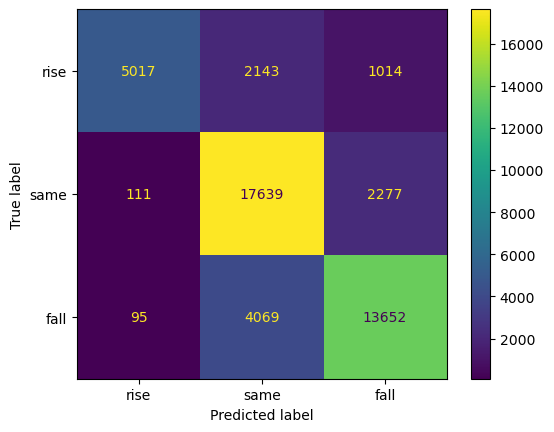

In [61]:
# 2330 台積電
keywords = ['台積電', '半導體', 'AI', '蘋果', 'Apple', '台灣積體電路', '臺灣積體電路', '張忠謀', '晶片', '晶圓', '護國神山']
stock_data_source = '微股力個股交易數據-2年'
content_data_source = ['內容數據新聞1', '內容數據新聞2', '內容數據新聞3', '討論數據mobile01-1', '討論數據mobile01-2', '討論數據ptt']
stock_symbol = '2330'
n_days_after = 5

phase_1_and_2(stock_data_source, content_data_source, stock_symbol, keywords, n_days_after)

In [62]:
# 2330 台積電
keywords = ['台積電', '半導體', 'AI', '蘋果', 'Apple', '台灣積體電路', '臺灣積體電路', '張忠謀', '晶片', '晶圓', '護國神山']
stock_data_source = '微股力個股交易數據-2年'
content_data_source = ['內容數據新聞1', '內容數據新聞2', '內容數據新聞3']
stock_symbol = '2330'
n_days_after = 5

phase_1_and_2(stock_data_source, content_data_source, stock_symbol, keywords, n_days_after)

/var/folders/gf/q242kxcx471dfq8lmv99k_y80000gn/T/ipykernel_42737/3807372300.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exchange_data['delta'] = exchange_data['close'] - exchange_data['open']
/var/folders/gf/q242kxcx471dfq8lmv99k_y80000gn/T/ipykernel_42737/3807372300.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exchange_data['gain_rate'] = exchange_data['delta'] / exchange_data['open']
/var/folders/gf/q242kxcx471dfq8lmv99k_y80000gn/T/ipykernel_42737/3807372300.py:41: SettingWithCopyWarning:

內容數據新聞1
內容數據新聞2
內容數據新聞3
object
(485492, 9)
(184883, 9)


/var/folders/gf/q242kxcx471dfq8lmv99k_y80000gn/T/ipykernel_42737/1163521706.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exchange_data['delta'] = exchange_data['close'] - exchange_data['open']
/var/folders/gf/q242kxcx471dfq8lmv99k_y80000gn/T/ipykernel_42737/1163521706.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exchange_data['gain_rate'] = exchange_data['delta'] / exchange_data['open']
/var/folders/gf/q242kxcx471dfq8lmv99k_y80000gn/T/ipykernel_42737/1163521706.py:38: SettingWithCopyWarning:

內容數據新聞1
內容數據新聞2
內容數據新聞3
討論數據mobile01-1
討論數據mobile01-2
討論數據ptt
(742961, 10)
(31856, 10)
['10' '11' '12' '2022' '2023' '2024' 'ai' 'ai 伺服' 'ai 伺服 伺服器' '三季' '上漲'
 '下半' '下半 下半年' '下半 下半年 半年' '下半年' '下半年 半年' '中國' '中心' '企業' '伺服' '伺服 伺服器'
 '伺服器' '供應' '供應 供應鏈' '供應鏈' '億元' '億美元' '億美元 美元' '全球' '公司' '出貨' '利率' '動能'
 '包括' '半導' '半導 半導體' '半導 半導體 導體' '半導體' '半導體 導體' '半年' '去年' '受惠' '可望' '台北'
 '合併' '同期' '增加' '外資' '客戶' '導體' '展望' '市場' '帶動' '平台' '庫存' '影響' '成長' '技術'
 '投資' '持續' '指出' '指數' '提升' '整體' '新高' '明年' '時報' '晶片' '智慧' '服務' '未來' '業務'
 '每股' '法人' '消費' '營運' '獲利' '產品' '產業' '發展' '相關' '看好' '科技' '第一' '第三' '系統'
 '經濟' '美元' '美國' '股價' '表現' '訂單' '資料' '趨勢' '運算' '雲端' '電子' '需求' '預估' '預期']
['10' '11' '12' '2022' '2023' '2024' 'ai' 'ai 伺服' 'ai 伺服 伺服器' '三季' '上漲'
 '下半' '下半 下半年' '下半 下半年 半年' '下半年' '下半年 半年' '中國' '中心' '企業' '伺服' '伺服 伺服器'
 '伺服器' '供應' '供應 供應鏈' '供應鏈' '億元' '億美元' '億美元 美元' '全球' '公司' '出貨' '利率' '動能'
 '包括' '半導' '半導 半導體' '半導 半導體 導體' '半導體' '半導體 導體' '半年' '去年' '受惠' '可望' '台北'
 '同期' '增加' '外資' '客戶' '導體' '展望' '市場' '帶動' '庫存' '影響' '成長

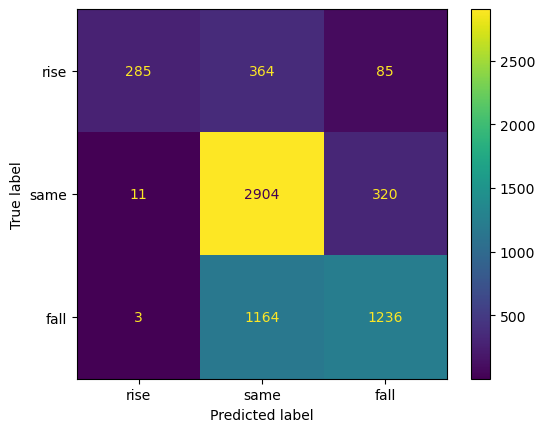

In [55]:
# 2059 川湖科技股份有限公司
stock_symbol = '2059'
keywords = ['川湖', '伺服器', '導軌', '林聰吉', 'King Slide', '雲端', '滑軌', '鉸鏈', '影印機', '集線器', '不斷電系統']
stock_data_source = '微股力個股交易數據-2年'
content_data_source = ['內容數據新聞1', '內容數據新聞2', '內容數據新聞3', '討論數據mobile01-1', '討論數據mobile01-2', '討論數據ptt']
n_days_after = 5


phase_1_and_2(stock_data_source, content_data_source, stock_symbol, keywords, n_days_after)

In [ ]:
# 2383 台光電子材料股份有限公司 (Not in 奇摩股市定義之AI概念股
stock_symbol = '2383'
keywords = ['台光電', '伺服器', '銅箔基板', '電路板', 'UBB', 'CCL', '電子', 'AI伺服器', 'PCB', '董定宇']
stock_data_source = '微股力個股交易數據-2年'
content_data_source = ['內容數據新聞1', '內容數據新聞2', '內容數據新聞3', '討論數據mobile01-1', '討論數據mobile01-2', '討論數據ptt']
n_days_after = 5


phase_1_and_2(stock_data_source, content_data_source, stock_symbol, keywords, n_days_after)

In [57]:
# 2454 聯發科技
stock_symbol = '2454'
keywords = ['聯發科', '發哥', '半導體', '路由器', '數位', '晶片', '蔡力行', '手機', '智慧終端', 'IC', '天璣']
stock_data_source = '微股力個股交易數據-2年'
content_data_source = ['內容數據新聞1', '內容數據新聞2', '內容數據新聞3', '討論數據mobile01-1', '討論數據mobile01-2', '討論數據ptt']
n_days_after = 5


phase_1_and_2(stock_data_source, content_data_source, stock_symbol, keywords, n_days_after)

/var/folders/gf/q242kxcx471dfq8lmv99k_y80000gn/T/ipykernel_42737/1163521706.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exchange_data['delta'] = exchange_data['close'] - exchange_data['open']
/var/folders/gf/q242kxcx471dfq8lmv99k_y80000gn/T/ipykernel_42737/1163521706.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exchange_data['gain_rate'] = exchange_data['delta'] / exchange_data['open']
/var/folders/gf/q242kxcx471dfq8lmv99k_y80000gn/T/ipykernel_42737/1163521706.py:38: SettingWithCopyWarning:

內容數據新聞1
內容數據新聞2
內容數據新聞3
討論數據mobile01-1
討論數據mobile01-2
討論數據ptt
(742961, 10)
(175703, 10)


AttributeError: 'float' object has no attribute 'decode'

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1, max_depth=7, random_state=0)
clf.fit(content_train_tfidf, y_train)
clf.score(content_train_tfidf, y_train)

0.9435808262800637